In [86]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import time

# Theory

### 1. What is a wavelet approximation?
A wavelet approximation is very similar to a Fourier approximation, expression a function as a linear combination of some orthogonal basis functions. The difference is that for Fourier, the basis is $\sin{x}$ and $\cos{x}$. For a wavelet approximation, the basis functions are two localized and orthogonal waves called *wavelets* $\psi_{jk}(x)$. We'll talk about the subscripts later.

$$ f(x) \approx \sum_{jk} c_{jk} \psi_{jk}(x)$$

### 2. What is a wavelet, $\psi_{jk}$?


Mathematically, the wavelets are functions in Hilbert space without the requirement of an inner-product, or $L^2(\mathbb{R})$ as the mathematicians call it. This is the space of all square integrable functions over real numbers (that is, for a function $g(x): \mathbb{R} \to \mathbb{C}$, $g(x) \in L^2(\mathbb{R}) \text{ iff } \int_{-\infty}^{\infty} |g(x)|^2 \text{d}x < \infty$).

The functions $\psi_{jk}(x)$ are defined by the following, for $j,k \in \mathbb{Z}$ and $x\in\mathbb{R}$ on the bounds from $[0,1]$:

$$ \psi_{jk} = 2^{j/2}\psi(2^j x - k). $$

For different bounds, $[a,b]$, where $L = b - a$, this is instead:

$$ \psi_{jk} = \frac{2^{j/2}}{\sqrt{L}} \psi\left(\frac{2^j (x-a)}{L} - k\right). $$

We'll ignore those constants added in for now, since they don't change much of anything (they do ensure an orthonormal basis though), but it'll be good to keep in mind for implementation.

Notice that $\psi_{00} = 2^0\psi(2^0 x - 0) = \psi(x)$, so $j=k=0$ leads to the "regular" version of our wavelet. 

Let's let $j=0$ to see the behavior of the parameter $k$:
$$ \psi_{0k} = 2^0\psi(2^0 x - k) = \psi(x - k) $$

The parameter $k$ thus controls shifts of $\psi$ by unit distances (since $k\in\mathbb{Z}$). 

Finally, we'll let $k=0$ and $j$ be free:
$$ \psi_{j0} = 2^{j/2} \psi (2^j x)$$

The parameter $j$ controls compression or de-localization of $\psi$. Large $j$ will make the wavelet more compressed, while small $j$ will make the wavelet more spread out.

### 3. Additional constraints on $\psi_{jk}$

Combining both of these, $\psi_jk(x)$ are scaled and translated versions of $\psi(x)$, which are said to form a *wavelet system* of $\psi$. The tricky bit is then finding a wavelet function $\psi_{kj}(x)$ for which **any function in $L^2(\mathbb{R})$** may be represented by the following double sum for a given set of coefficients $\{c_{jk}\}$:

$$ f(x) \approx \sum_{jk} c_{jk} \psi_{jk}(x)$$

It's very common to also impose the extra condition that $\psi_{jk}(x)$ form an orthonormal basis, equivalent to saying $\int_{-\infty}^{\infty} \psi_{jk}(x)\psi_{lm}^*(x) \text{d}x = \delta_{jl}\delta_{km}$. This is not necessary, but it does make finding $c_{jk}$ FAR easier, so we're going to do it.

$$ c_{jk} = \int_{-\infty}^{\infty} f(x) \psi_{jk}^*(x) \text{d}x $$

What we're doing there is essentially decomposing $f(x)$ to find the components of each wavelet that make it up.

There are additional constraints on $\psi$ that may be imposed for certain problems, such as $\psi$ being smooth, infinitely differentiable, computationally convenient (piecewise polynomial for example), having compact support (function values are zero outside some bounded range), or the Fourier transform of $\psi$ having compact support. I suspect we won't require these for $f(x) = \sin x$, though.

The final thing is that, when we start summing to approximate $\sin{x}$, we need to know what $j$ and $k$ to perform the double sum over. The canonical choice is to set some maximum resolution level $J$, where each $j \in \{0,1,\dots,J-1\}$ gets finer and finer details of the function (since $j$ controls the dilation of the wavelet). This choice ensures that our wavelets $\psi_{jk}$ can't spread outside our desired domain. For $k$, we sum over $k \in \{0,1,\dots, 2^j - 1\}$, ensuring that exactly $2^j$ non-overlapping wavelets fit in the range (since $k$ controls the horizontal translation).

### 4. Haar wavelet

There are a few different options of things that satisfy all those constraints. The first, and easiest, was given by Haar in 1910:
\begin{align*}
    \psi(x) = \begin{cases}
        1, &x \in [0,\frac{1}{2}) \\ 
        -1, &x \in [\frac{1}{2},1) \\ 
        0, &\text{otherwise}
    \end{cases}
\end{align*}
This has the problem of discontinuity at $x \in \{-1,0,1\}$, which can cause problems in signal quality (even if $f(x)$ is infinitely differentiable, the output signal will be discontinuous, since we will always only ever have a finite number of terms in the wavelet expansion.) But other wavelets are kind of really complicated, so I'll deal with that in a bitsies

### 5. Finding $c_{jk}$

The next step is finding the $c_{jk}$ for this $\psi$, and since we're concerned about the domain $[0,2\pi]$, those will be the bounds of the integral rather than $\pm \infty$. Note that our wavelets are real, so the complex conjugation doesn't do anything. We'll also use the full form of $\psi_{jk}$ with $b=2\pi$ and $a = 0$, then with $L= 2\pi$.

\begin{align*}
    c_{jk} &= \int_0^{2\pi} f(x) \psi_{jk}^*(x)\text{d}x \\
    &= \int_{0}^{2\pi} \sin x \left[\frac{2^{j/2}}{\sqrt{2\pi}}\psi\left(\frac{2^j x}{2\pi} - k\right)\right]\text{d}x \\
    &= \sqrt{\frac{2^j}{2\pi}} \int_{0}^{2\pi} \sin (x)\psi\left(\frac{2^j x}{2\pi} - k\right)\text{d}x \\
\end{align*}

Letting $u = \frac{2^j x}{2\pi} - k$, so $\text{d}u = \frac{2^j}{2\pi} \text{d}x$ and $x = \frac{2\pi (u+k)}{2^j}$, we find the integral becomes:

\begin{align*}
    c_{jk} &= \sqrt{\frac{2\pi}{2^j}}\int_{-k}^{2^j - k} \sin \left(\frac{2\pi (u+k)}{2^j}\right) \psi(u)\text{d}u
\end{align*}

Now, we know for the Haar wavelet that $\psi(u) = 1$ on $u\in[0,\frac{1}{2})$ and $\psi(u) = -1$ on $u\in[\frac{1}{2},1)$. Comparing those bounds to the bounds of the integral, $k$ is guaranteed positive by the conditions we imposed earlier, so $0$ is greater than $-k$, and $1$ is greater than $2^j - k$ since $k$ is at most $2^j - 1$. Thus, we can substitute $\psi(u)$ with $\pm 1$ over the appropriate bounds.

\begin{align*}
    c_{jk} &= \sqrt{\frac{2\pi}{2^j}}
    \left[\int_{0}^{1/2} \sin \left(\frac{2\pi (u+k)}{2^j}\right) \text{d}u
        - \int_{1/2}^{1} \sin \left(\frac{2\pi (u+k)}{2^j}\right) \text{d}u\right]
\end{align*}

We'll then resubstitute back to $x$ to get a nice closed-form solution. As before, $x = \frac{2\pi (u+k)}{2^j}$,
so $\text{d}x = \frac{2\pi}{2^j}\text{d}u$

\begin{align*}
    c_{jk} &= \sqrt{\frac{2^j}{2\pi}}
    \left[\int_{2\pi k / 2^j}^{2\pi (k+\frac{1}{2}) / 2^j} \sin x \text{d}x
        - \int_{2\pi (k+\frac{1}{2}) / 2^j}^{2\pi (k+1) / 2^j} \sin x \text{d}x\right] \\
    &= \sqrt{\frac{2^j}{2\pi}}\left[
        \left[\cos\left(\frac{2\pi (k+1)}{2^j}\right) - \cos\left(\frac{2\pi (k+\frac{1}{2})}{2^j}\right)\right]
      - \left[\cos\left(\frac{2\pi (k+\frac{1}{2})}{2^j}\right) - \cos\left(\frac{2\pi k}{2^j}\right)\right] 
    \right] \\
    &= \sqrt{\frac{2^j}{2\pi}}\left[
        \cos\left(\frac{2\pi (k+1)}{2^j}\right) - 2\cos\left(\frac{2\pi (k+\frac{1}{2})}{2^j}\right) 
        + \cos\left(\frac{2\pi k}{2^j}\right) 
    \right] \\
\end{align*}

We'll make one last batch of simplifications with some trig identities. Letting $\alpha = \frac{2\pi k}{2^j}$ and $\beta = \frac{1}{2}\cdot\frac{2\pi}{2^j} = \frac{\pi}{2^j}$, the terms inside the brackets become:

\begin{align*}
    &\cos\left(\frac{2\pi (k+1)}{2^j}\right) - 2\cos\left(\frac{2\pi (k+\frac{1}{2})}{2^j}\right) 
    + \cos\left(\frac{2\pi k}{2^j}\right) \\
    &= \left[\cos(\alpha + 2\beta) - \cos\left(\alpha + \beta\right)\right] + 
    \left[\cos(\alpha) - \cos\left(\alpha + \beta\right)\right]
\end{align*}

Using the $\cos$ subtraction identity where $\cos A - \cos B = -2\sin\left(\frac{A+B}{2}\right)\sin\left(\frac{A-B}{2}\right)$, the first group of terms has $A_1=\alpha + 2\beta$ and $B_1 = \alpha + \beta$, so $A_1 + B_1 = 2\alpha + 3\beta$
and $A_1 - B_1 = \beta$. For the second group of terms we see $A_2 = \alpha$ and $B_2 = \alpha + \beta$, so $A_2 + B_2 = 2\alpha + \beta$ and $A_2 - B_2 = -\beta$. All of that together simplifies to:

\begin{align*}
    &= \left[-2\sin\left(\alpha + \frac{3}{2}\beta\right)\sin\left(\frac{\beta}{2}\right)\right]
     + \left[-2\sin\left(\alpha + \frac{\beta}{2}\right)\sin\left(-\frac{\beta}{2}\right)\right] \\
    &= 2\sin\left(\frac{\beta}{2}\right)\left[\sin\left(\alpha + \frac{\beta}{2}\right)
        -\sin\left(\alpha + \frac{3\beta}{2}\right) \right]
\end{align*}

Here, we can then apply the $\sin$ subtraction identity where $\sin A - \sin B = 2\cos\left(\frac{A+B}{2}\right)\sin\left(\frac{A-B}{2}\right)$. With $A = \alpha + \frac{\beta}{2}$ and $B = \alpha + \frac{3\beta}{2}$, we see that $A+B = 2\alpha+ 2\beta$ and $A - B = -\beta$, so the above becomes:

\begin{align*}
    &= 2\sin\left(\frac{\beta}{2}\right)\left[2\cos\left(\alpha + \beta\right)\sin\left(-\frac{\beta}{2}\right)\right] \\
    &= -4\sin^2\left(\frac{\beta}{2}\right)\cos\left(\alpha + \beta\right)
\end{align*}

We can then substitute all that back in to get our finalest closed-form expression for the coefficients $c_{jk}$:

\begin{align*}
    c_{jk} &= -4\sqrt{\frac{2^j}{2\pi}}\sin^2\left(\frac{\pi}{2^{j+1}}\right)\cos\left(\frac{2\pi (k+\frac{1}{2})}{2^j}\right)
\end{align*}

You may notice (this was a big hang-up for me), that these coefficients that we're using to approximate the $\sin$ function require us to use the $\sin$ function to compute them. After reading up some, the only answer I have to that is this a pedagogical test case. In a normal application of wavelet approximations, the integral for $c_{jk}$ couldn't be computed exactly and would necessarily use some numerical approach. We have the benefit of being able to analytically evaluate the function, and we're just using this as a way to benchmark the method, so there's some circular reasoning necessarily baked in.

# Code I : First implementation attempt.

In [87]:
def psi_haar(x):
    '''
    Haar wavelet base case, \psi_00.
    '''
    if 0 <= x < 0.5:
        return 1
    elif 0.5 <= x < 1:
        return -1
    else:
        return 0

def psi(j:int, k:int, x:float, wavelet = psi_haar):
    '''
    Defines \psi_{jk}(x) for a given base wavelet \psi_00. 

    Parameters
    ----------
    j, k : int
        Parameters of the wavelet. j controls compactness, k controls translation
    x : float
        The function value being approximated
    wavelet : Callable
        Base case functions psi_00. Default is the Haar wavelet
    '''
    return np.sqrt(2**j / (2*np.pi)) * wavelet((2**j * x)/(2*np.pi) - k)

In [88]:
def c_jk_haar(j, k):
    return -4*np.sqrt(2**j / (2*np.pi)) * np.sin(np.pi / (2**(j+1)))**2 * np.cos(2*np.pi*(k+0.5)/2**j)

In [89]:
def f_approx(x, max_resolution): 
    '''
    Approximate f(x) by \sum_{jk} c_{jk} \psi_{jk}(x)

    Parameters
    ----------
    x : float
        Position we're approximating f(x) at
    max_resolution : int
        The value J, where we divide the approximation into J regions to pick up finer details
    '''
    f = 0
    j_list = np.array([i for i in range(0, max_resolution)]) # j = 0, 1, ..., J - 1
    for j in j_list:
        k_list = np.array([i for i in range(0, 2**j)]) # k = 0, 1, ..., 2^j - 1
        for k in k_list:
            f += c_jk_haar(j,k) * psi(j,k,x)
    return f

In [90]:
num_points = 100
x_range = np.linspace(0, 2*np.pi, num_points)

In [91]:
sin_approx_list = [f_approx(x, 10) for x in x_range]

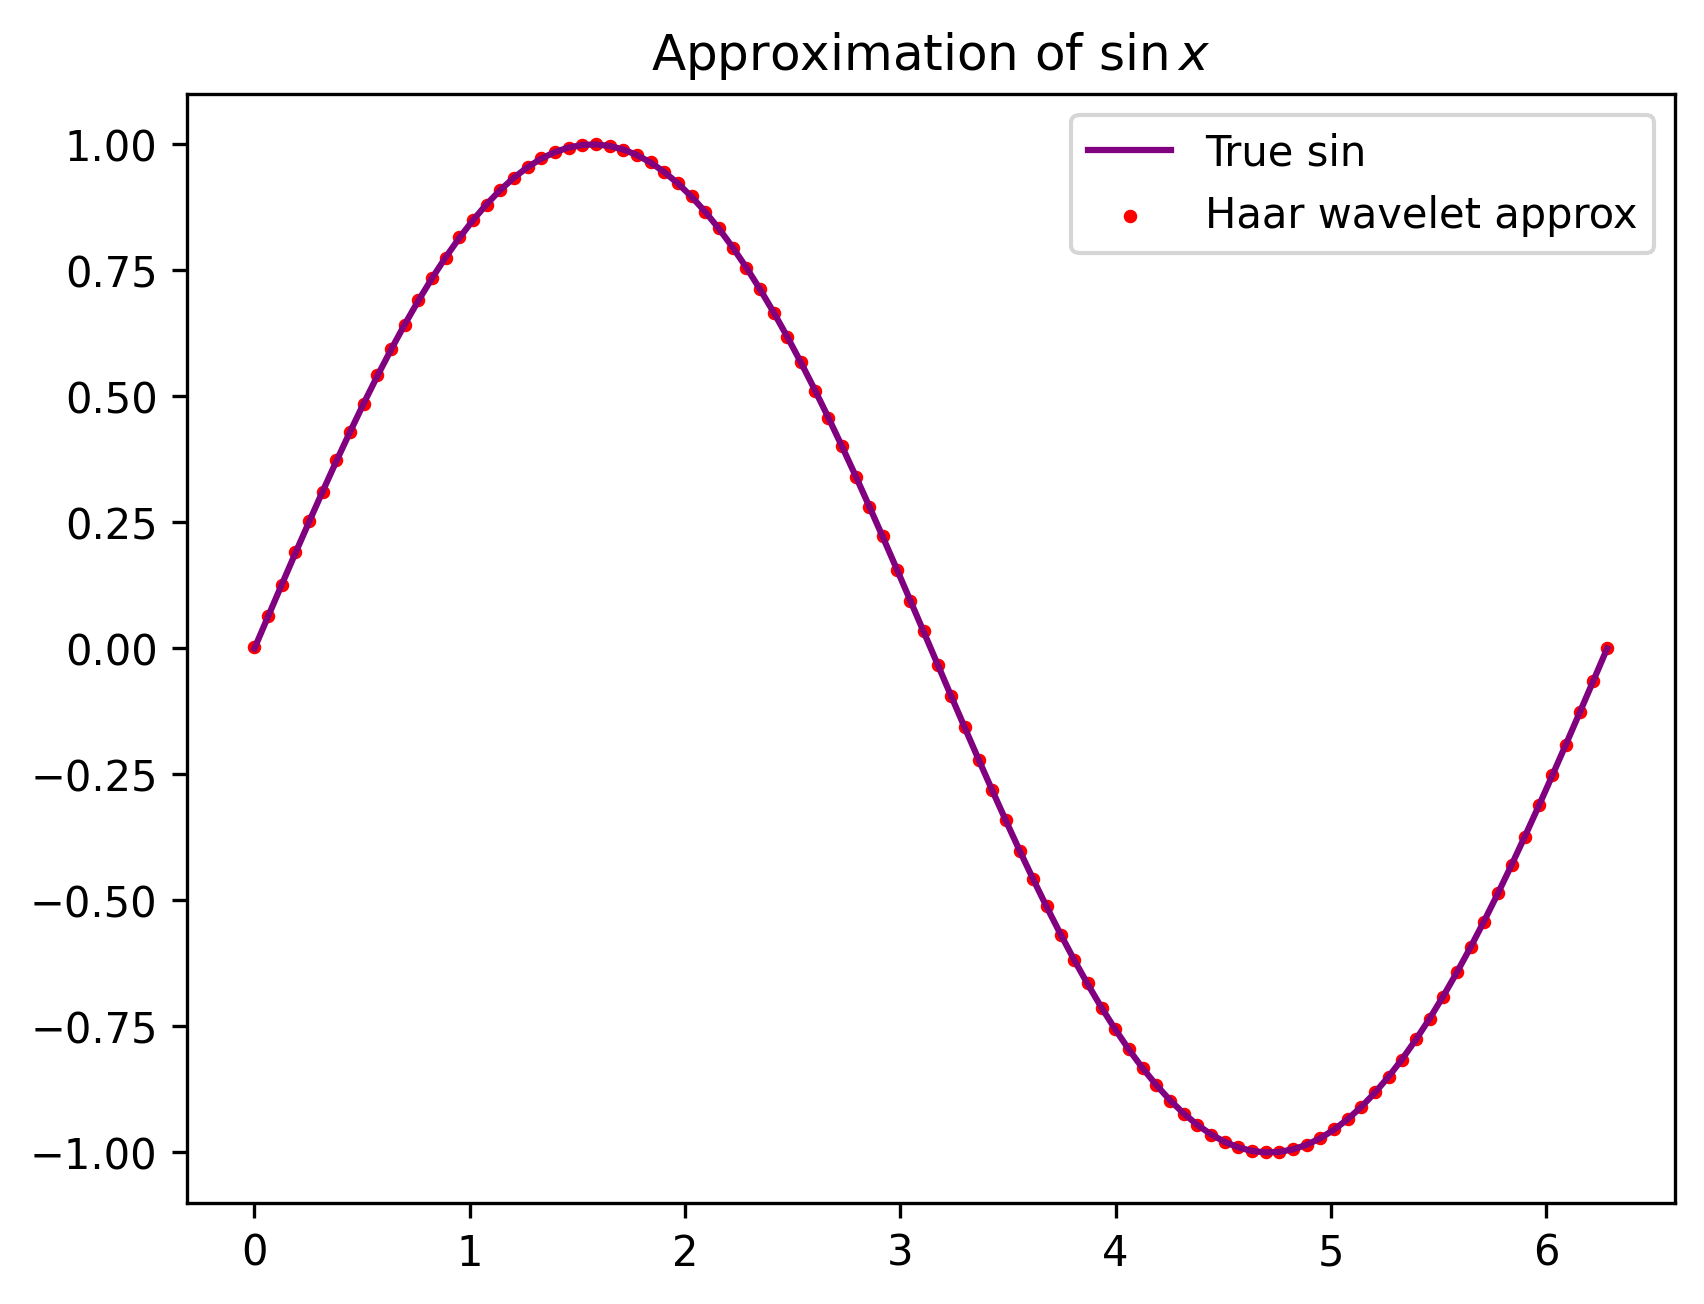

In [92]:
plt.plot(x_range, [np.sin(x) for x in x_range], color='purple', label='True sin')
plt.scatter(x_range, sin_approx_list, color='red', s=5, label='Haar wavelet approx')
plt.title(rf"Approximation of $\sin x$")
plt.legend()
plt.show()

This works! (Hallelujah) But its really quite slow. Admittedly, we're using a large $J$ of 10, so for the last $j$ we're computing a *lot* of $c_{jk}$. Step two will be doing it all better.

# Code II: Making it better

In [93]:
from numpy.typing import NDArray

In [94]:
def psi_haar_vec(x: NDArray):
    '''
    Haar wavelet base case, \psi_00. Now vectorized.
    '''
    return np.where((x >= 0) & (x < 0.5), 1, np.where((x >= 0.5) & (x < 1), -1, 0))

def psi_vec(x: NDArray, j:int, wavelet = psi_haar_vec):
    '''
    Defines \psi_{jk}(x) for a given base wavelet \psi_00. Now vectorized

    Parameters
    ----------
    j, k : int
        Parameters of the wavelet. j controls compactness, k controls translation
    x : NDArray
        Array of points at which we wish to evaluate the function
    wavelet : Callable
        Base case functions psi_00. Default is the Haar wavelet

    Returns
    -------
    psi(x) : NDarray (2**j, len(x))
        Array of psi(x) evaluated at each x, for each allowed k  of a given j.
    '''
    k = np.arange(2**j).reshape(-1, 1)
    return np.sqrt(2**j / (2*np.pi)) * wavelet((2**j * x)/(2*np.pi) - k)

In [95]:
def c_jk_haar_vec(j):
    k = np.arange(2**j)
    return -4*np.sqrt(2**j / (2*np.pi)) * np.sin(np.pi / (2**(j+1)))**2 * np.cos(2*np.pi*(k+0.5)/2**j)

In [96]:
def f_approx_vec(x: NDArray, max_resolution):
    f_sum = np.zeros_like(x, dtype=float)
    c_jk_list = [c_jk_haar_vec(j) for j in range(max_resolution)]
    for j, cjk in enumerate(c_jk_list):
        psi = psi_vec(x, j)  # shape (2^j, len(x))
        f_sum += np.sum(cjk[:, None] * psi, axis=0)
    return f_sum

In [97]:
num_points = 500
x_range = np.linspace(0, 2*np.pi, num_points)

In [98]:
f_approx = f_approx_vec(x_range, 8)

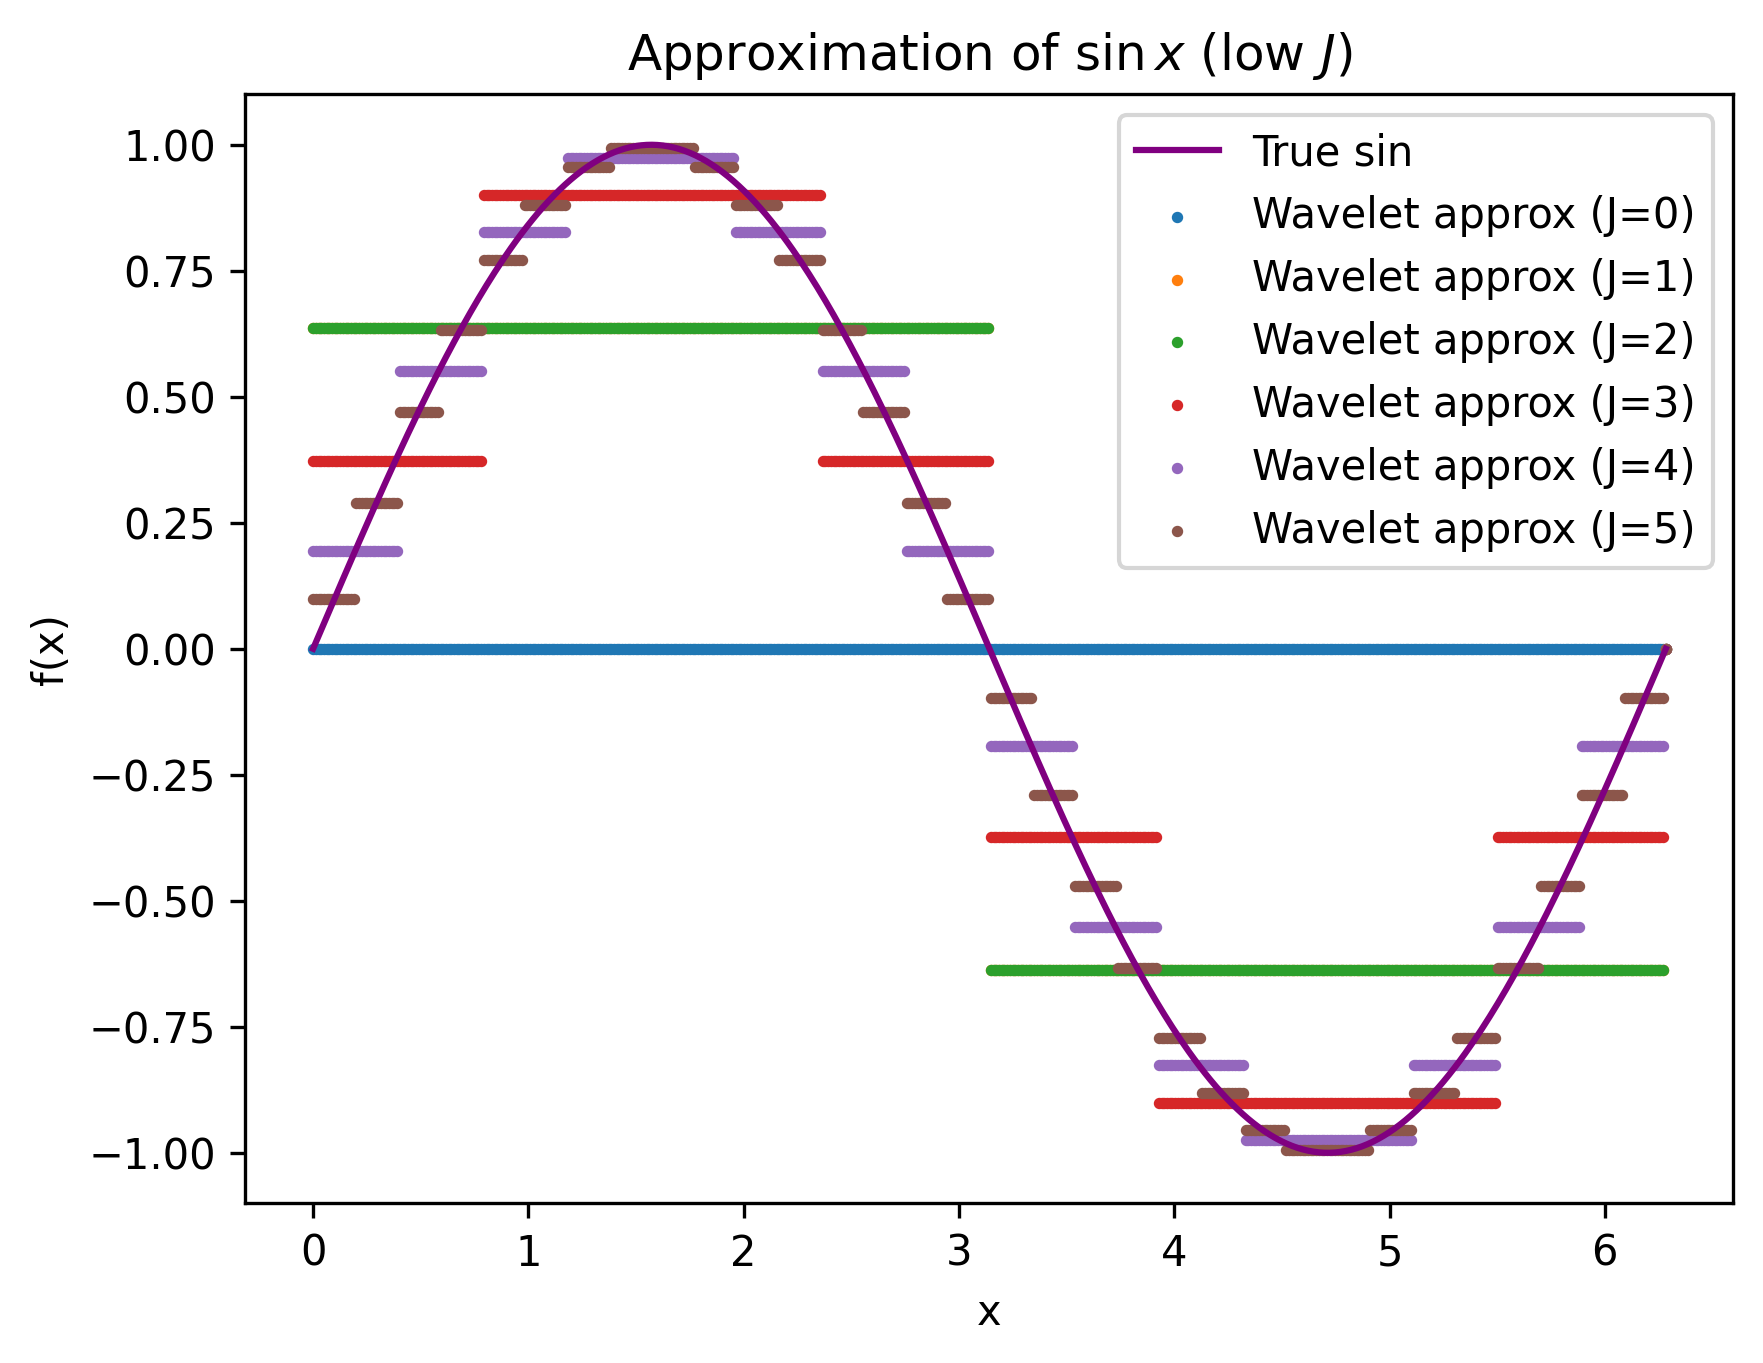

In [99]:
plt.plot(x_range, [np.sin(x) for x in x_range], color='purple', label='True sin')
for i in range(6):
    plt.scatter(x_range, f_approx_vec(x_range, i), s=3, label=f'Wavelet approx (J={i})')
plt.title(r"Approximation of $\sin x$ (low $J$)")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

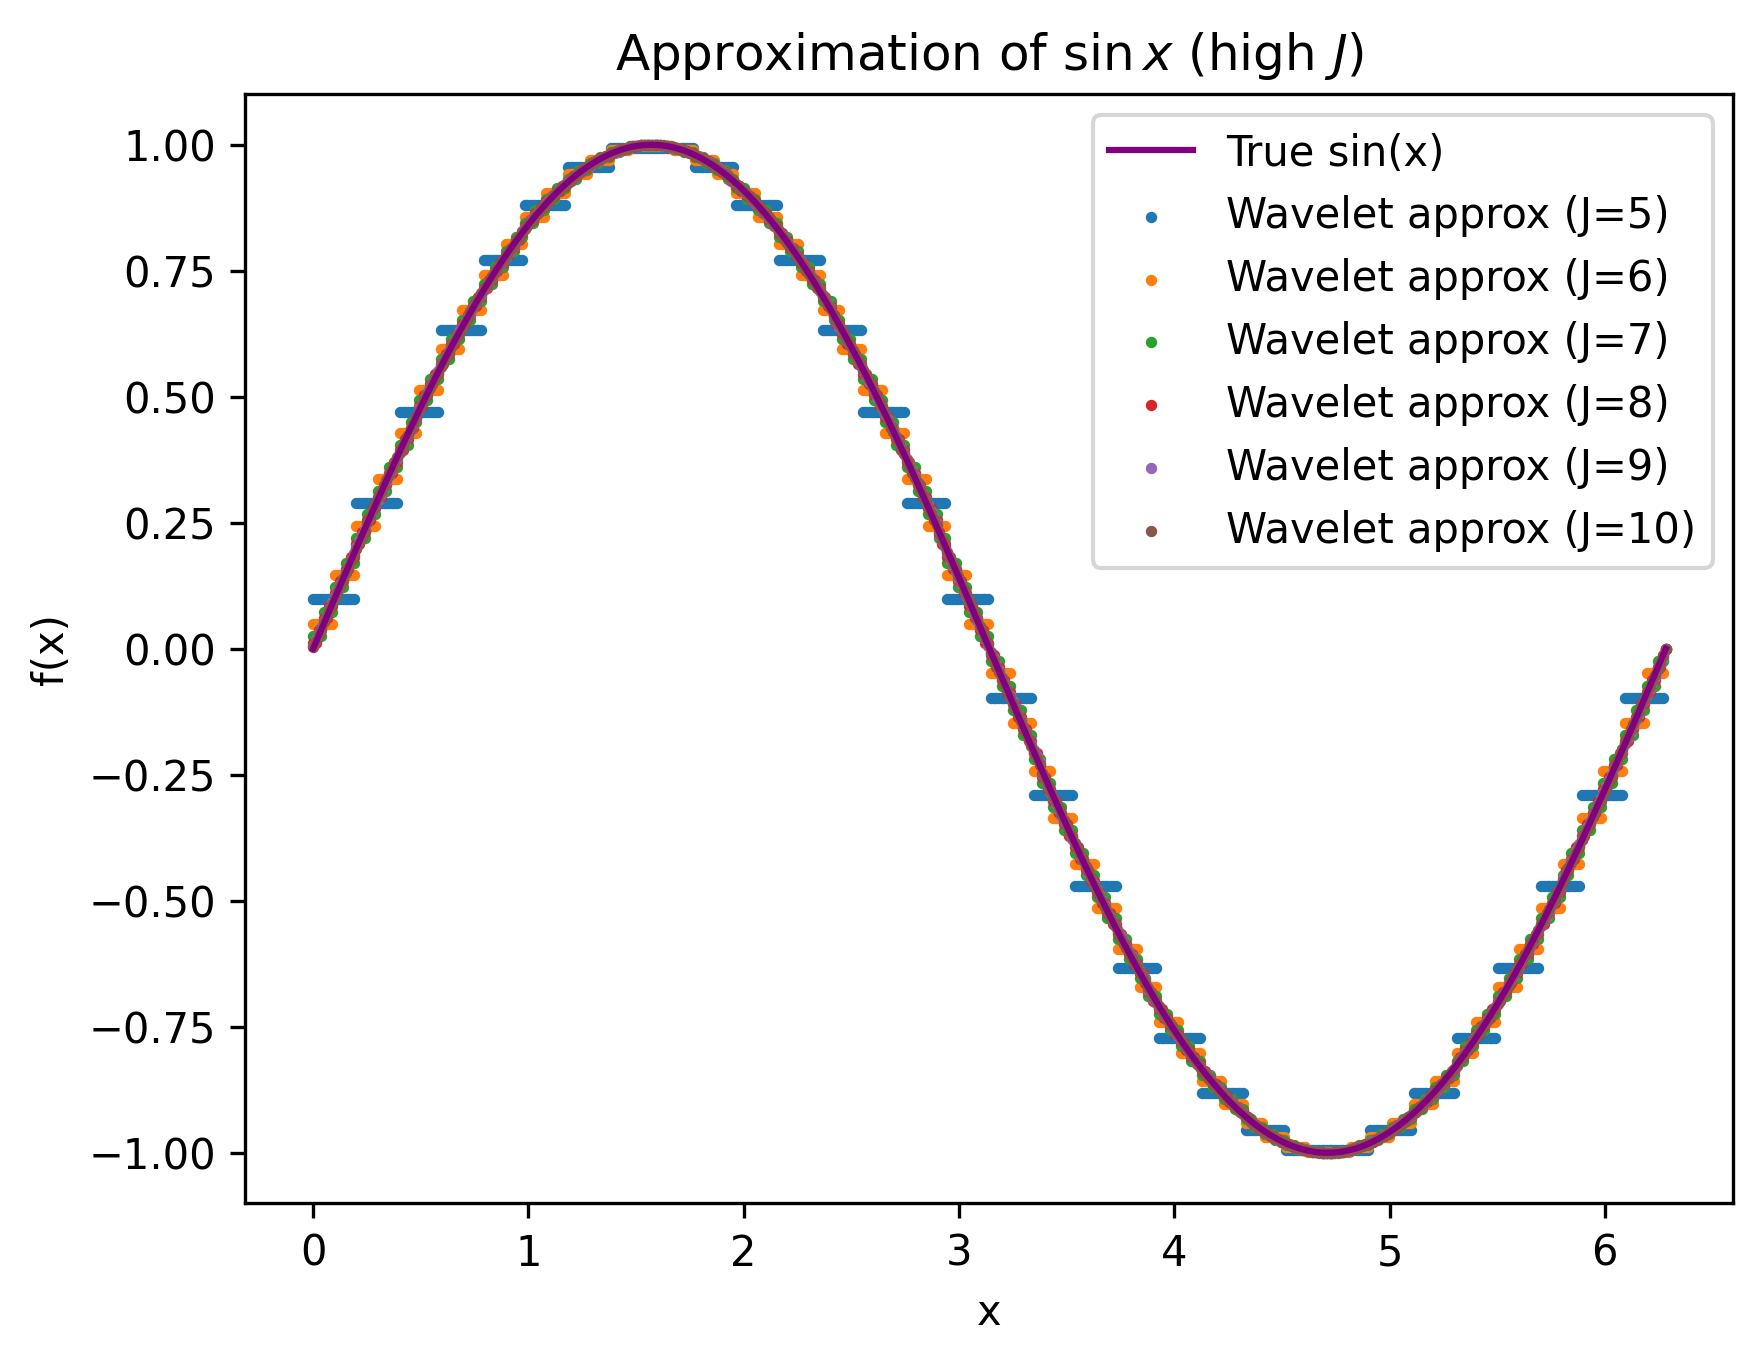

In [100]:
plt.plot(x_range, [np.sin(x) for x in x_range], color='purple', label='True sin(x)')
for i in range(6):
    i = i + 5
    plt.scatter(x_range, f_approx_vec(x_range, i), s=3, label=f'Wavelet approx (J={i})')
plt.title(rf"Approximation of $\sin x$ (high $J$)")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

WAY better timing-wise. We'll time it and look at accuracy now that its not bad.

# Code III: Analysis

In [101]:
max_J = 15
J_ls = [J for J in range(max_J + 1)]

results = {}

for J in J_ls:
    true_sin = np.sin(x_range)
    start_time = time.time()
    approx_sin = f_approx_vec(x_range, J)
    runtime = time.time() - start_time

    rmse_error = np.sqrt(np.mean(np.abs(true_sin - approx_sin)**2))

    results[J] = {
        "time": runtime,
        "rmse_error": rmse_error
    }

### Plots

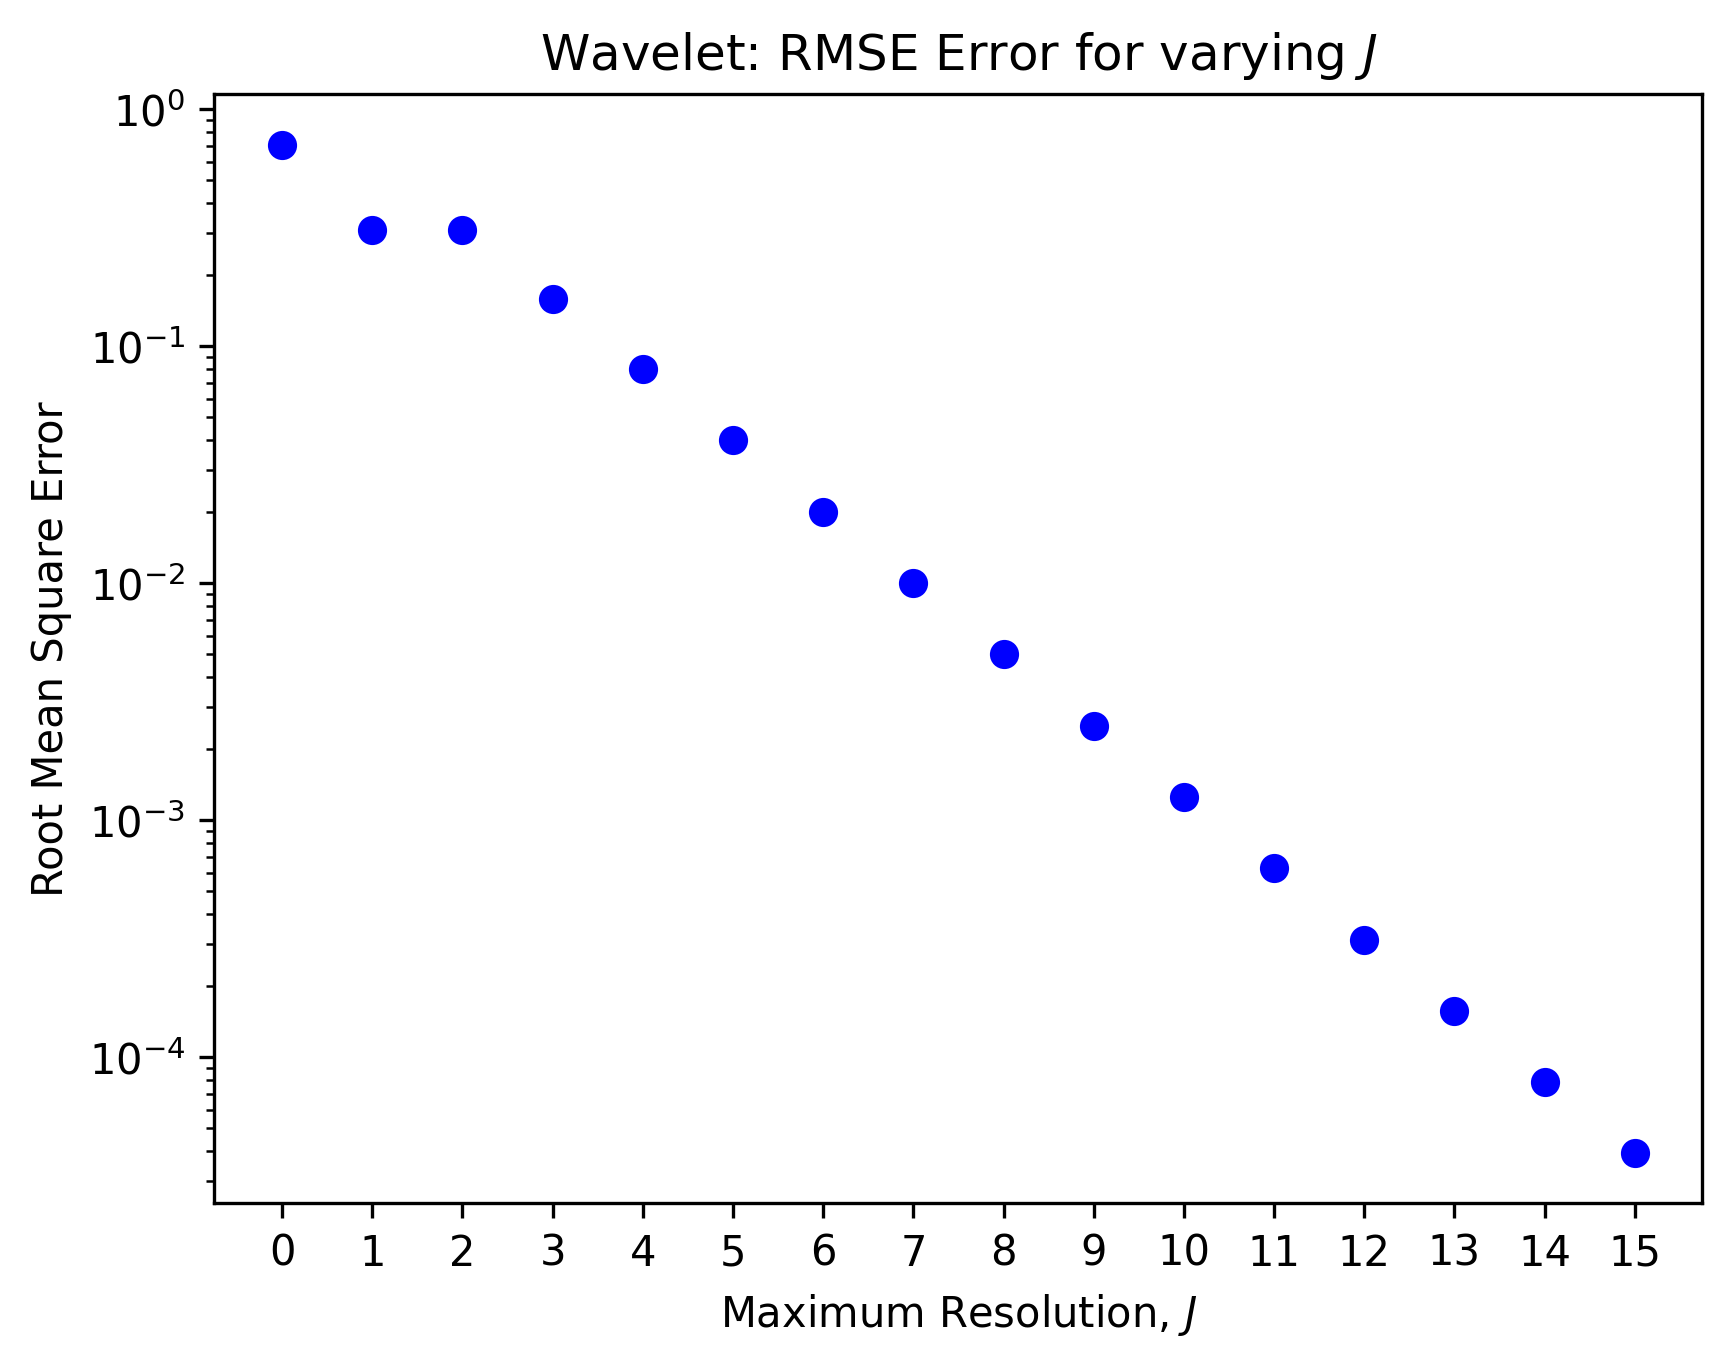

In [102]:
plt.scatter(J_ls, [results[J]["rmse_error"] for J in J_ls], color = "blue")
plt.xticks(J_ls)
plt.yscale('log')
plt.title(r"Wavelet: RMSE Error for varying $J$")
plt.xlabel(r"Maximum Resolution, $J$")
plt.ylabel("Root Mean Square Error")
plt.show()

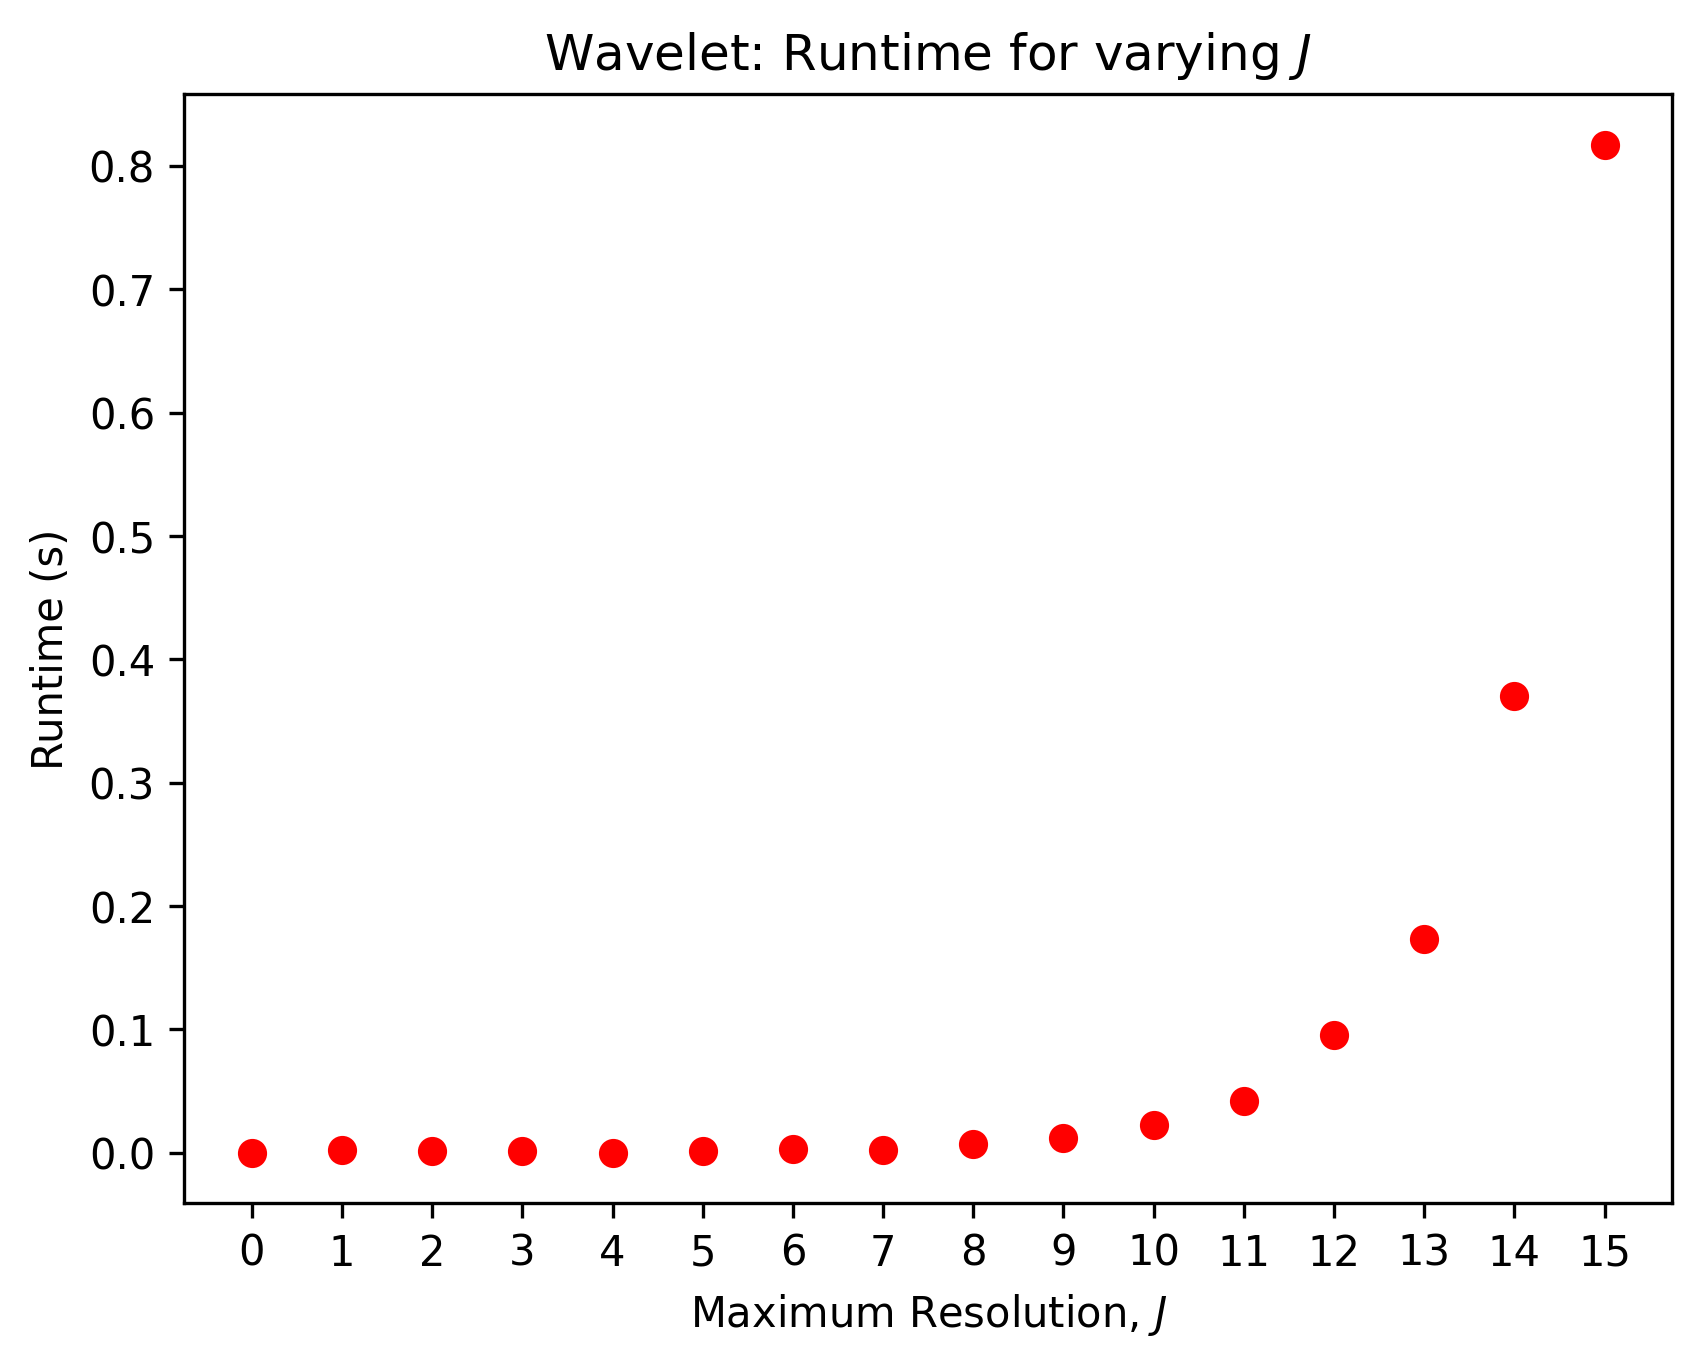

In [103]:
plt.scatter(J_ls, [results[J]["time"] for J in J_ls], color="red")
plt.xticks(J_ls)
#plt.yscale('log')
plt.title(r"Wavelet: Runtime for varying $J$")
plt.xlabel(r"Maximum Resolution, $J$")
plt.ylabel("Runtime (s)")
plt.show()

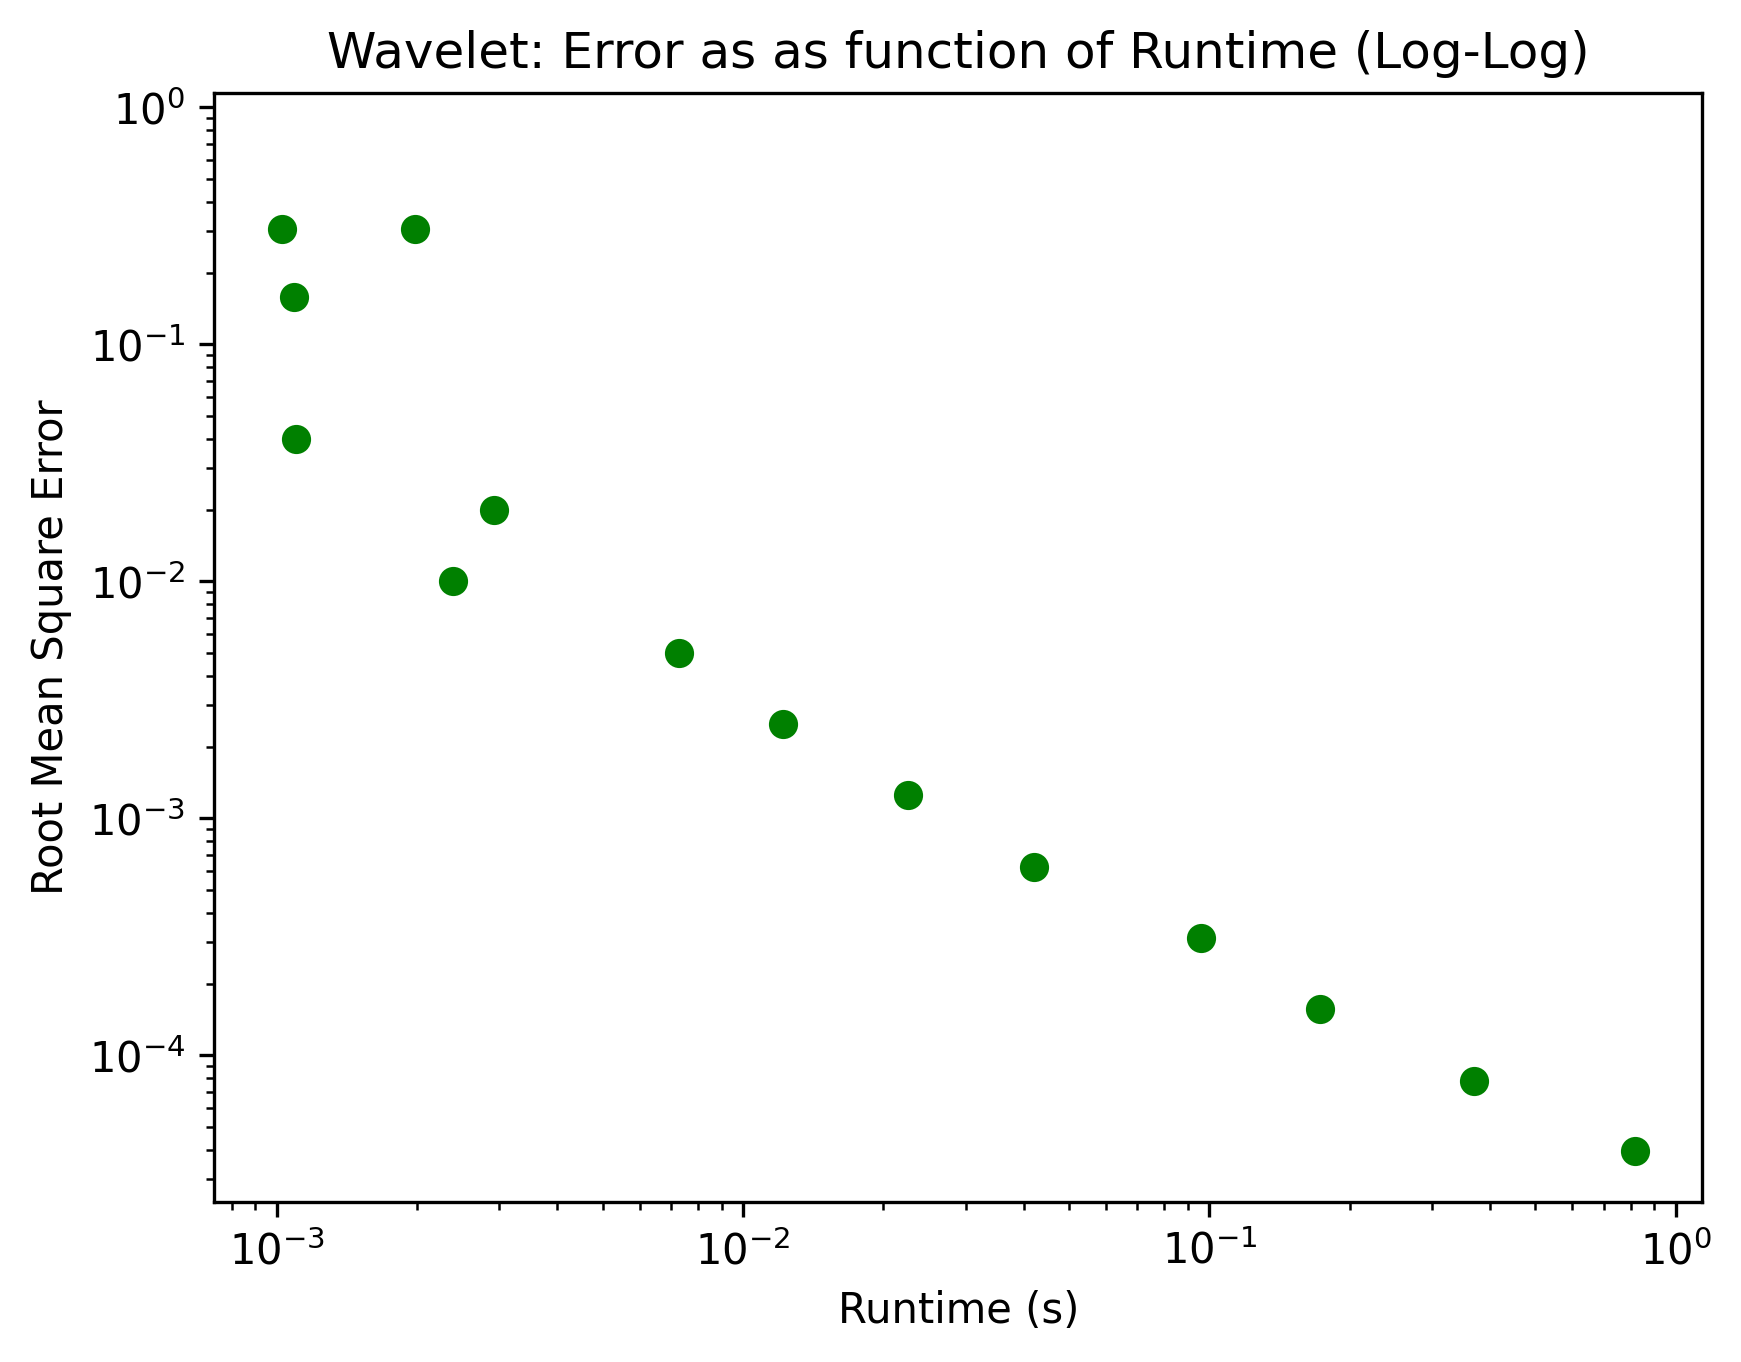

In [104]:
plt.scatter([results[J]["time"] for J in J_ls], [results[J]["rmse_error"] for J in J_ls], color="green")
plt.xscale('log')
plt.yscale('log')
plt.title("Wavelet: Error as as function of Runtime (Log-Log)")
plt.xlabel("Runtime (s)")
plt.ylabel("Root Mean Square Error")
plt.show()

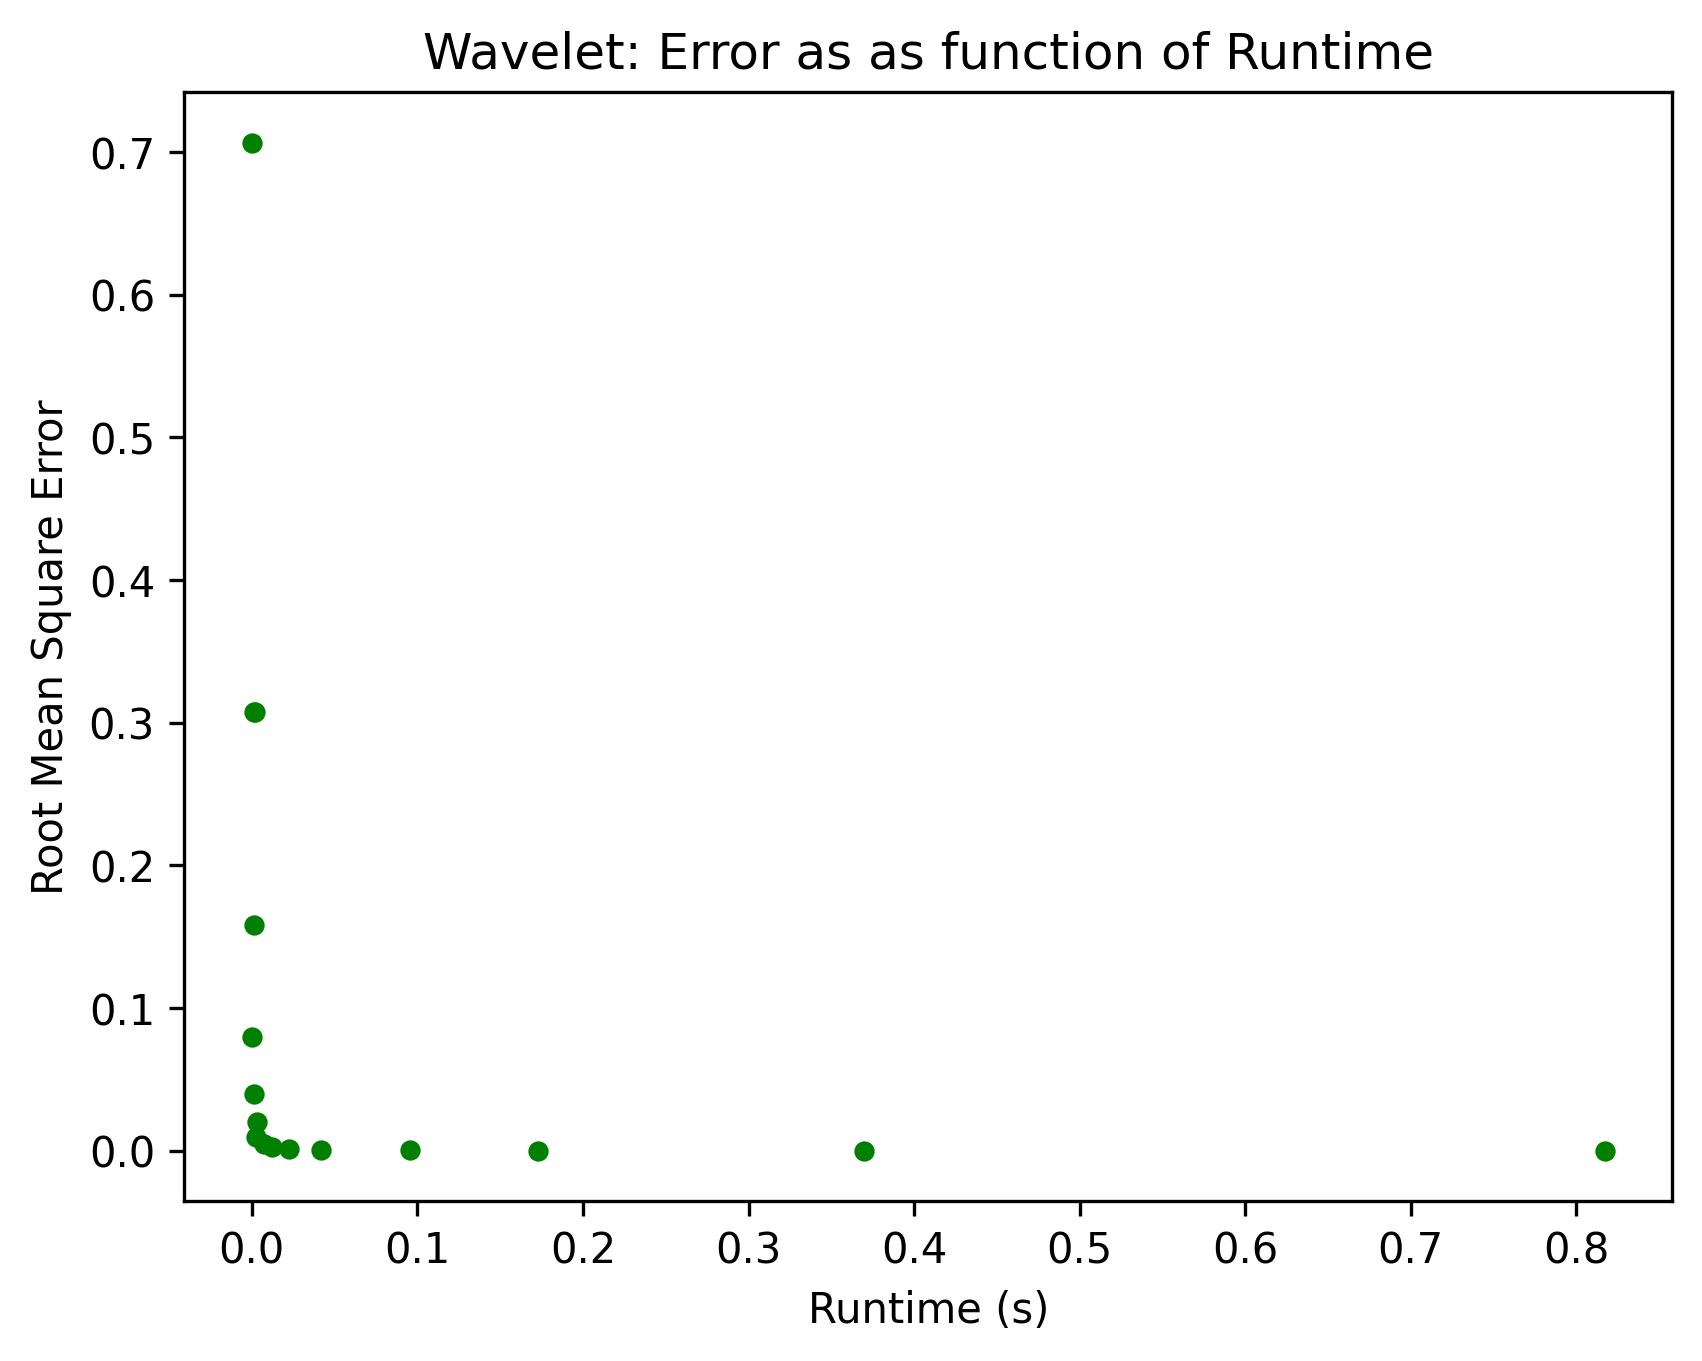

In [105]:
plt.scatter([results[J]["time"] for J in J_ls], [results[J]["rmse_error"] for J in J_ls], color="green", s=15)
plt.title("Wavelet: Error as as function of Runtime")
plt.xlabel("Runtime (s)")
plt.ylabel("Root Mean Square Error")
plt.show()

Through trial and error, we found any bigger than $J = 15$ messed up our scale: runtimes got too high.

# Code IV : Visualizing Wavelets

This maybe should have been first, but I didn't think to do it until now after the time/error analysis. So I'll do that now.

In [106]:
wavelets = {}
for j in J_ls:
    psi = psi_vec(x_range, j)
    wavelets[j] = psi.T

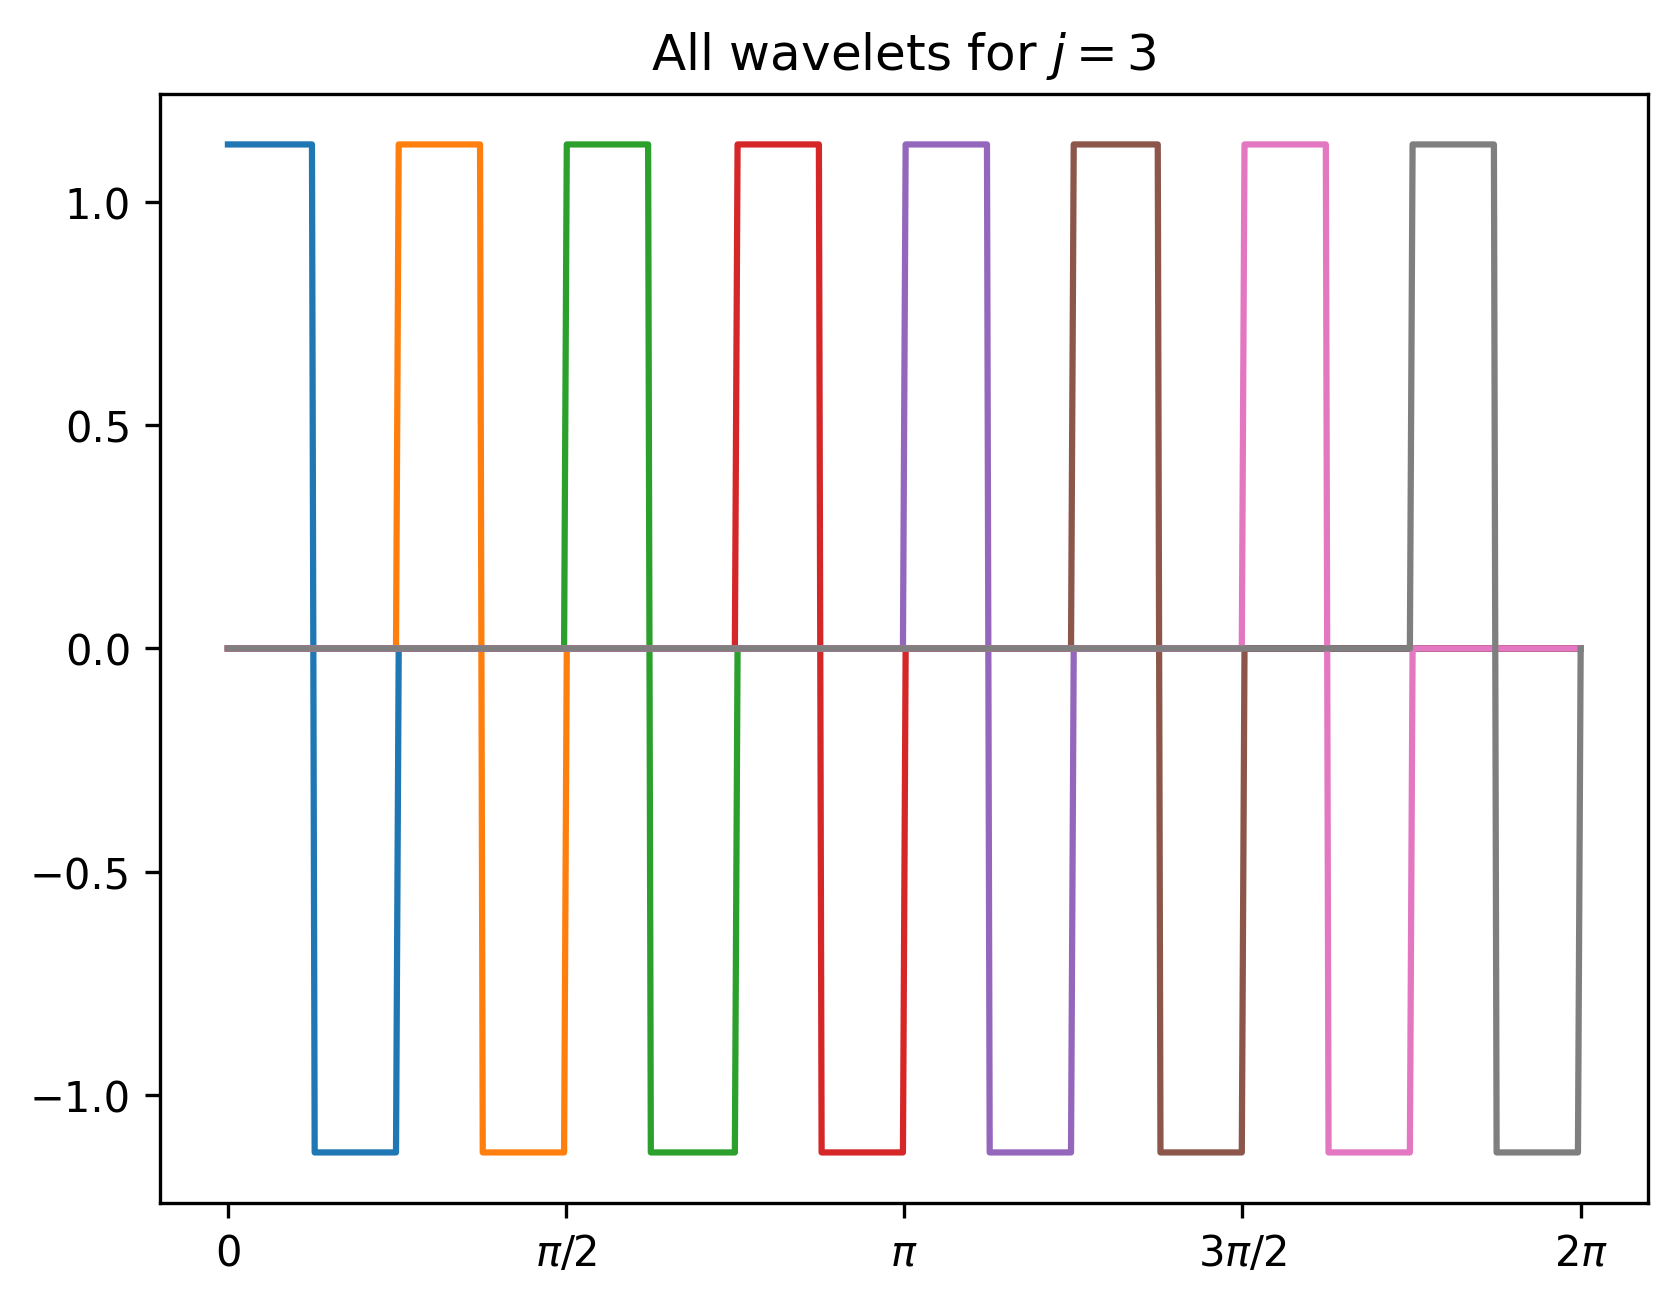

In [118]:
j = 3
plt.plot(x_range, wavelets[j])
#for i in range(wavelets[3].shape[1]):
#    plt.scatter(x_range, wavelets[3][:, i], s=10)  # s sets marker size

plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plt.title(rf"All wavelets for $j={j}$")
plt.show()

I think this is pretty illustrative of what happens with the wavelets. Using a resolution parameter of $j=3$, we get $k=2^j=8$ different wavelets, which are evenly distributed on the interval from $0$ to $2\pi$, and zero outside of their interval of length $\frac{2\pi}{8}$. By computing the coefficients $c_{jk}$ of how much the $\sin$ function "lines up" with each of these wavelets, we can reconstruct $\sin$ by taking linear combinations of those coefficients times the particular wavelet.